In [1]:
import pickle
import sys
import os
from torchvision.ops import nms
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import src.GLIP.maskrcnn_benchmark as maskrcnn_benchmark

sys.modules['maskrcnn_benchmark'] = maskrcnn_benchmark

In [2]:
dataset = pickle.load(open('../data/dataset_for_segmentation.p','rb'))
dataset.head()

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,caption_preprocessed,title_raw,title_preprocessed
0,1027,JOMU_32980_2k_324w.jpg,people buying sweets at the market.,GLIP,caption,"[tensor(0.8280), tensor(0.7924), tensor(0.6899...","[[tensor(178.8594), tensor(116.5122), tensor(2...","[people, people, people, people, people, peopl...",1488.0,people buying sweets at the market.,people buying sweets at the market.,"Saint Nicholas Festival Market, Place de Notre...","saint nicholas festival market, place de notre..."
1,183,CAPO_02480_2k_324w.jpg,a group of soldiers stand in front of a building.,GLIP,caption,"[tensor(0.8242), tensor(0.5884), tensor(0.5781...","[[tensor(0.8775), tensor(131.9302), tensor(81....","[soldiers, a building, a building, a building]",516.0,a group of soldiers stand in front of a building.,a group of soldiers stand in front of a building.,[Mobilization at Perolles in August 1914],[mobilization at perolles in august 1914]
2,543,JATH_26232_2k_324w.jpg,soldiers stand in front of a military vehicle.,GLIP,caption,"[tensor(0.7898), tensor(0.7305), tensor(0.6872...","[[tensor(97.0861), tensor(137.5495), tensor(14...","[soldiers, soldiers, a military vehicle, soldi...",950.0,soldiers stand in front of a military vehicle.,soldiers stand in front of a military vehicle.,"Additional service for women, Barracks de la P...","additional service for women, barracks de la p..."
3,430,JATH_10616_2k_324w.jpg,women walking down a street.,GLIP,caption,"[tensor(0.6900), tensor(0.6777), tensor(0.6676...","[[tensor(125.4207), tensor(111.6184), tensor(1...","[women, women, women, a street, women]",836.0,women walking down a street.,women walking down a street.,Procession on the route to the Alps during a w...,procession on the route to the alps during a w...
4,408,HAWI_01023_2k_324w.jpg,a photograph of a large tropical cyclone.,GLIP,caption,[tensor(0.7263)],"[[tensor(4.5861), tensor(13.1419), tensor(318....",[a large tropical cyclone],814.0,a photograph of a large tropical cyclone.,a a large tropical cyclone.,Tornado over Lake Morat,tornado over lake morat


In [3]:
pickle_dir = '../data/phrase_grounding_results/'
MDETR_caption = pickle.load(open(pickle_dir + 'MDETR_full_caption.p', 'rb'))
MDETR_title = pickle.load(open(pickle_dir + 'MDETR_full_title.p', 'rb'))
GLIP_caption = pickle.load(open(pickle_dir + 'GLIP_full_caption.p', 'rb'))
GLIP_title = pickle.load(open(pickle_dir + 'GLIP_full_title.p', 'rb'))
dataset_dict = pickle.load(open('../data/dataset_for_phrase_grounding/dataset.p', 'rb'))

In [4]:
def GLIP2MDETR(glip_array):
    mdetr_array = []
    for elem in glip_array:
        caption = [elem[1][k -1] if k < len(elem[1]) else elem[1][len(elem[1]) - 1] for k in elem[0].get_field('labels')]
        mdetr_array.append([elem[0].get_field('scores'), elem[0].bbox, caption])
    return mdetr_array
GLIP_caption = GLIP2MDETR(GLIP_caption)
GLIP_title = GLIP2MDETR(GLIP_title)

In [5]:
def det_nms(segmentation_array):
    segmentation_array_ = []
    for i, elem in enumerate(segmentation_array):
        segmentation_array_.append(list(elem))
    seg_filtered = copy.deepcopy(segmentation_array_)
    for index_, elem in enumerate(segmentation_array_):
        unique_caption = set(elem[2])
        if len(elem[2]) != 0:
            boolean_index = [[elem_ == cap for elem_ in elem[2]] for cap in list(unique_caption)]
            idx = [[i for i, x in enumerate(bool_idx) if x] for bool_idx in boolean_index]
            idx_to_keep = [nms(boxes=torch.index_select(elem[1], 0, torch.tensor(idx_)),
                               scores=torch.index_select(elem[0], 0, torch.tensor(idx_)), iou_threshold=0.2) for idx_ in
                           idx]
            scores = []
            boxes = []
            captions = []
            for idx_, idx_tokeep, caption in zip(idx, idx_to_keep, list(unique_caption)):
                scores += (elem[0][idx_][idx_tokeep])
                boxes += (elem[1][idx_][idx_tokeep])
                captions += (
                    [elem[2][i].removeprefix(' ') for i in torch.index_select(torch.tensor(idx_), 0, idx_tokeep)])

            seg_filtered[index_][0] = torch.stack(scores, dim=0)
            seg_filtered[index_][1] = torch.stack(boxes, dim=0)
            seg_filtered[index_][2] = captions

    return seg_filtered


def global_det_nms(segmentation_array):
    segmentation_array_ = []
    for i, elem in enumerate(segmentation_array):
        segmentation_array_.append(list(elem))
    seg_filtered = copy.deepcopy(segmentation_array_)
    for index_, elem in enumerate(segmentation_array_):
        if len(elem[2]) != 0:
            idx_to_keep = nms(boxes=elem[1], scores=elem[0], iou_threshold=0.9)
            scores = []
            boxes = []
            captions = []
            scores += (elem[0][idx_to_keep])
            boxes += (elem[1][idx_to_keep])
            captions += ([elem[2][i].removeprefix(' ') for i in idx_to_keep])

            seg_filtered[index_][0] = torch.stack(scores, dim=0)
            seg_filtered[index_][1] = torch.stack(boxes, dim=0)
            seg_filtered[index_][2] = captions

    return seg_filtered

In [6]:
MDETR_caption = global_det_nms(det_nms(MDETR_caption))
MDETR_title = global_det_nms(det_nms(MDETR_title))
GLIP_caption = global_det_nms(det_nms(GLIP_caption))
GLIP_title = global_det_nms(det_nms(GLIP_title))

In [7]:
MDETR_title = pd.DataFrame(MDETR_title).rename({0:'conf', 1:'bbox', 2:'expr'}, axis=1)
MDETR_caption = pd.DataFrame(MDETR_caption).rename({0:'conf', 1:'bbox', 2:'expr'}, axis=1)
GLIP_caption = pd.DataFrame(GLIP_caption).rename({0:'conf', 1:'bbox', 2:'expr'}, axis=1)
GLIP_title = pd.DataFrame(GLIP_title).rename({0:'conf', 1:'bbox', 2:'expr'}, axis=1)
MDETR_title.head()

,conf,bbox,expr
0,"[tensor(0.9756), tensor(0.9001), tensor(0.8900)]","[[tensor(65.0094), tensor(1.1163), tensor(324....","[the wall of father girard, inauguration plaqu..."
1,[tensor(0.9990)],"[[tensor(81.8896), tensor(160.1014), tensor(22...",[patient of dr xavier cuony city]
2,[tensor(0.9510)],"[[tensor(86.9352), tensor(87.6198), tensor(244...",[felsenegg]
3,"[tensor(0.9978), tensor(0.9940)]","[[tensor(39.9502), tensor(162.3252), tensor(27...","[his bike, male ( hermann nussbaumer]"
4,"[tensor(0.9960), tensor(0.9914), tensor(0.9859...","[[tensor(141.7642), tensor(84.6272), tensor(27...","[two women one, two women one, regional costum..."


In [8]:
# for each element in the dataset, we want to filter results that have confidence < 0.75
# import compress
from itertools import compress

def filter_results(elem):
    conf = elem['conf']
    bbox = elem['bbox']
    expr = elem['expr']
    keep = conf > 0.75
    conf = conf[keep]
    bbox = bbox[keep]
    expr = list(compress(expr, keep))

    return {'conf': conf, 'bbox': bbox, 'expr': expr}

def filter_results_df(df):
    new_df = df.copy()
    df = df.apply(filter_results, axis=1)
    new_df['conf'] = df.apply(lambda x: x['conf'])
    new_df['bbox'] = df.apply(lambda x: x['bbox'])
    new_df['expr'] = df.apply(lambda x: x['expr'])
    return new_df

MDETR_title = filter_results_df(MDETR_title)
MDETR_caption = filter_results_df(MDETR_caption)

In [9]:
def get_min_bbox(bbox):
    try:
        return int((bbox[:,2:] - bbox[:,:2]).prod(axis=1).min())
    except:
        return np.nan

def get_max_bbox(bbox):
    try:
        return int((bbox[:,2:] - bbox[:,:2]).prod(axis=1).max())
    except:
        return np.nan

def get_median_bbox(bbox):
    try:
        return int((bbox[:,2:] - bbox[:,:2]).prod(axis=1).median())
    except:
        return np.nan

MDETR_title['num_bbox'] = MDETR_title.conf.apply(lambda x: len(x))
MDETR_caption['num_bbox'] = MDETR_caption.conf.apply(lambda x: len(x))
GLIP_caption['num_bbox'] = GLIP_caption.conf.apply(lambda x: len(x))
GLIP_title['num_bbox'] = GLIP_title.conf.apply(lambda x: len(x))

MDETR_title['min_bbox_area'] = MDETR_title.bbox.apply(lambda x: get_min_bbox(x))
MDETR_caption['min_bbox_area'] = MDETR_caption.bbox.apply(lambda x: get_min_bbox(x))
GLIP_caption['min_bbox_area'] = GLIP_caption.bbox.apply(lambda x: get_min_bbox(x))
GLIP_title['min_bbox_area'] = GLIP_title.bbox.apply(lambda x: get_min_bbox(x))

MDETR_title['max_bbox_area'] = MDETR_title.bbox.apply(lambda x: get_max_bbox(x))
MDETR_caption['max_bbox_area'] = MDETR_caption.bbox.apply(lambda x: get_max_bbox(x))
GLIP_caption['max_bbox_area'] = GLIP_caption.bbox.apply(lambda x: get_max_bbox(x))
GLIP_title['max_bbox_area'] = GLIP_title.bbox.apply(lambda x: get_max_bbox(x))

MDETR_title['median_bbox_area'] = MDETR_title.bbox.apply(lambda x: get_median_bbox(x))
MDETR_caption['median_bbox_area'] = MDETR_caption.bbox.apply(lambda x: get_median_bbox(x))
GLIP_caption['median_bbox_area'] = GLIP_caption.bbox.apply(lambda x: get_median_bbox(x))
GLIP_title['median_bbox_area'] = GLIP_title.bbox.apply(lambda x: get_median_bbox(x))


MDETR_title.drop(columns=['conf', 'bbox', 'expr'], inplace=True)
MDETR_caption.drop(columns=['conf', 'bbox', 'expr'], inplace=True)
GLIP_caption.drop(columns=['conf', 'bbox', 'expr'], inplace=True)
GLIP_title.drop(columns=['conf', 'bbox', 'expr'], inplace=True)

In [10]:
dataset_dict = pd.DataFrame(dataset_dict)

In [11]:
dataset_dict['len_caption'] = dataset_dict.caption.apply(lambda x: len(x['raw'].split()) if x['raw'] is not None else 0)
dataset_dict['len_title'] = dataset_dict.title.apply(lambda x: len(x['raw'].split()) if x['raw'] is not None else 0)

In [12]:
dataset_dict = dataset_dict.drop(columns=['title', 'caption'])
dataset_dict.head()

,image_id,filename,len_caption,len_title
0,2,ALCU_00005_2k_324w.jpg,6,18
1,4,ALCU_00033_2k_324w.jpg,5,8
2,5,ALNU_00015_2k_324w.jpg,8,5
3,6,ALNU_00016_2k_324w.jpg,7,6
4,7,ALNU_00052_2k_324w.jpg,7,6


In [13]:
dataset_dict = pd.merge(dataset_dict, MDETR_title, left_index=True, right_index=True).rename({'num_bbox': 'num_bbox_MDETR_title', 'min_bbox_area': 'min_bbox_area_MDETR_title', 'max_bbox_area': 'max_bbox_area_MDETR_title', 'median_bbox_area': 'median_bbox_area_MDETR_title'}, axis=1)
dataset_dict = pd.merge(dataset_dict, MDETR_caption, left_index=True, right_index=True).rename({'num_bbox': 'num_bbox_MDETR_caption', 'min_bbox_area': 'min_bbox_area_MDETR_caption', 'max_bbox_area': 'max_bbox_area_MDETR_caption', 'median_bbox_area': 'median_bbox_area_MDETR_caption'}, axis=1)
dataset_dict = pd.merge(dataset_dict, GLIP_caption, left_index=True, right_index=True).rename({'num_bbox': 'num_bbox_GLIP_caption', 'min_bbox_area': 'min_bbox_area_GLIP_caption', 'max_bbox_area': 'max_bbox_area_GLIP_caption', 'median_bbox_area': 'median_bbox_area_GLIP_caption'}, axis=1)
dataset_dict = pd.merge(dataset_dict, GLIP_title, left_index=True, right_index=True).rename({'num_bbox': 'num_bbox_GLIP_title', 'min_bbox_area': 'min_bbox_area_GLIP_title', 'max_bbox_area': 'max_bbox_area_GLIP_title', 'median_bbox_area': 'median_bbox_area_GLIP_title'}, axis=1)
dataset_dict.head()

,image_id,filename,len_caption,len_title,num_bbox_MDETR_title,min_bbox_area_MDETR_title,max_bbox_area_MDETR_title,median_bbox_area_MDETR_title,num_bbox_MDETR_caption,min_bbox_area_MDETR_caption,max_bbox_area_MDETR_caption,median_bbox_area_MDETR_caption,num_bbox_GLIP_caption,min_bbox_area_GLIP_caption,max_bbox_area_GLIP_caption,median_bbox_area_GLIP_caption,num_bbox_GLIP_title,min_bbox_area_GLIP_title,max_bbox_area_GLIP_title,median_bbox_area_GLIP_title
0,2,ALCU_00005_2k_324w.jpg,6,18,3,708.0,85733.0,1182.0,3,6862.0,50244.0,42928.0,1,53361.0,53361.0,53361.0,1,2266.0,2266.0,2266.0
1,4,ALCU_00033_2k_324w.jpg,5,8,1,37941.0,37941.0,37941.0,2,39104.0,146906.0,39104.0,1,42747.0,42747.0,42747.0,1,42669.0,42669.0,42669.0
2,5,ALNU_00015_2k_324w.jpg,8,5,1,52499.0,52499.0,52499.0,1,50734.0,50734.0,50734.0,1,52736.0,52736.0,52736.0,1,53524.0,53524.0,53524.0
3,6,ALNU_00016_2k_324w.jpg,7,6,2,44221.0,62845.0,44221.0,2,41603.0,62280.0,41603.0,1,42702.0,42702.0,42702.0,2,41893.0,67260.0,41893.0
4,7,ALNU_00052_2k_324w.jpg,7,6,5,26689.0,67220.0,33665.0,2,68115.0,113862.0,68115.0,3,32610.0,117776.0,39382.0,3,33316.0,66190.0,39599.0


In [14]:
dataset.head()

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,caption_preprocessed,title_raw,title_preprocessed
0,1027,JOMU_32980_2k_324w.jpg,people buying sweets at the market.,GLIP,caption,"[tensor(0.8280), tensor(0.7924), tensor(0.6899...","[[tensor(178.8594), tensor(116.5122), tensor(2...","[people, people, people, people, people, peopl...",1488.0,people buying sweets at the market.,people buying sweets at the market.,"Saint Nicholas Festival Market, Place de Notre...","saint nicholas festival market, place de notre..."
1,183,CAPO_02480_2k_324w.jpg,a group of soldiers stand in front of a building.,GLIP,caption,"[tensor(0.8242), tensor(0.5884), tensor(0.5781...","[[tensor(0.8775), tensor(131.9302), tensor(81....","[soldiers, a building, a building, a building]",516.0,a group of soldiers stand in front of a building.,a group of soldiers stand in front of a building.,[Mobilization at Perolles in August 1914],[mobilization at perolles in august 1914]
2,543,JATH_26232_2k_324w.jpg,soldiers stand in front of a military vehicle.,GLIP,caption,"[tensor(0.7898), tensor(0.7305), tensor(0.6872...","[[tensor(97.0861), tensor(137.5495), tensor(14...","[soldiers, soldiers, a military vehicle, soldi...",950.0,soldiers stand in front of a military vehicle.,soldiers stand in front of a military vehicle.,"Additional service for women, Barracks de la P...","additional service for women, barracks de la p..."
3,430,JATH_10616_2k_324w.jpg,women walking down a street.,GLIP,caption,"[tensor(0.6900), tensor(0.6777), tensor(0.6676...","[[tensor(125.4207), tensor(111.6184), tensor(1...","[women, women, women, a street, women]",836.0,women walking down a street.,women walking down a street.,Procession on the route to the Alps during a w...,procession on the route to the alps during a w...
4,408,HAWI_01023_2k_324w.jpg,a photograph of a large tropical cyclone.,GLIP,caption,[tensor(0.7263)],"[[tensor(4.5861), tensor(13.1419), tensor(318....",[a large tropical cyclone],814.0,a photograph of a large tropical cyclone.,a a large tropical cyclone.,Tornado over Lake Morat,tornado over lake morat


In [15]:
merged_dataset = pd.merge(dataset, dataset_dict.drop('image_id', axis=1), left_on='filename', right_on='filename', how='left')

In [16]:
def get_choice(x):
    if x['model'] == 'GLIP' and x['expr'] == 'caption':
        return np.array([1,0,0,0])
    elif x['model'] == 'GLIP' and x['expr'] == 'title':
        return np.array([0,1,0,0])
    elif x['model'] == 'MDETR' and x['expr'] == 'caption':
        return np.array([0,0,1,0])
    elif x['model'] == 'MDETR' and x['expr'] == 'title':
        return np.array([0,0,0,1])
merged_dataset['choice'] = merged_dataset.apply(lambda x: get_choice(x), axis=1)

In [17]:
merged_dataset.model.value_counts()

GLIP     1354
MDETR     106
Name: model, dtype: int64

In [18]:
merged_dataset.expr.value_counts()

caption    1221
title       239
Name: expr, dtype: int64

In [19]:
merged_dataset['isGLIP'] = merged_dataset.model.apply(lambda x: x=='GLIP')
merged_dataset['isCaption'] = merged_dataset.expr.apply(lambda x: x=='caption')

In [20]:
((merged_dataset.model == 'GLIP') & (merged_dataset.expr==('caption'))).sum()

1130

In [21]:
((merged_dataset.model == 'GLIP') & (merged_dataset.expr==('title'))).sum()

224

In [22]:
((merged_dataset.model == 'MDETR') & (merged_dataset.expr==('caption'))).sum()

91

In [23]:
((merged_dataset.model == 'MDETR') & (merged_dataset.expr==('title'))).sum()

15

|         | MDETR | GLIP |
|---------|-------|------|
| Caption | 91    | 1130 |
| Title   | 15    | 224  |

In [24]:
merged_dataset['conf'] =  merged_dataset.conf.apply(lambda x: torch.tensor(x).numpy())
merged_dataset['bbox'] =  merged_dataset.bbox.apply(lambda x: torch.tensor(x).numpy())

/tmp/ipykernel_47564/1317892172.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  merged_dataset['conf'] =  merged_dataset.conf.apply(lambda x: torch.tensor(x).numpy())
/tmp/ipykernel_47564/1317892172.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  merged_dataset['bbox'] =  merged_dataset.bbox.apply(lambda x: torch.tensor(x).numpy())


In [32]:
labels = np.stack(np.array(merged_dataset['choice']))
features= merged_dataset.drop(['choice', 'idx', 'filename', 'caption', 'caption_raw', 'caption_preprocessed', 'title_raw', 'title_preprocessed', 'model', 'expr', 'isGLIP', 'isCaption', 'labels', 'conf', 'bbox'], axis = 1).fillna(0)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [33]:
features

array([[1.4880e+03, 6.0000e+00, 9.0000e+00, ..., 1.0236e+05, 1.0236e+05,
        1.0236e+05],
       [5.1600e+02, 1.0000e+01, 6.0000e+00, ..., 4.0021e+04, 4.0021e+04,
        4.0021e+04],
       [9.5000e+02, 8.0000e+00, 9.0000e+00, ..., 2.7530e+03, 5.5180e+03,
        2.7530e+03],
       ...,
       [7.0500e+02, 5.0000e+00, 7.0000e+00, ..., 2.6954e+04, 6.2835e+04,
        2.6954e+04],
       [7.3600e+02, 5.0000e+00, 1.0000e+01, ..., 1.0966e+04, 2.4082e+04,
        1.0966e+04],
       [1.9600e+02, 7.0000e+00, 1.2000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [34]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (1095, 19)
Training Labels Shape: (1095, 4)
Testing Features Shape: (365, 19)
Testing Labels Shape: (365, 4)


In [35]:
# The baseline predictions are the historical averages
baseline_preds = np.array([1,0,0,0])
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.1


In [30]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [36]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [37]:

class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.relu(nn.Dense(features=self.num_hidden)(x))
        x = nn.relu(nn.Dense(features=self.num_hidden)(x))
        x = nn.relu(nn.Dense(features=self.num_hidden)(x))
        x = nn.Dense(features=self.num_outputs)(x)
        return x

# Same as JAX version but using model.apply().
@jax.jit
def mse(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)


model = SimpleClassifierCompact(num_hidden=8, num_outputs=4)
batch = jnp.ones((8, 19))
params = model.init(jax.random.PRNGKey(0), batch)

class PyDataset(data.Dataset):

    def __init__(self, features, label, seed=42):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.np_rng = np.random.RandomState(seed=seed)
        self.features = features
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return len(self.label)

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.features[idx]
        data_label = self.label[idx]
        return data_point, data_label

train_dataset = PyDataset(train_features, train_labels)

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


tx = optax.sgd(learning_rate=0.001)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(mse)

from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=tx)


def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc


@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

train_data_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)


2022-12-25 13:03:23.334995: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [38]:
from tqdm import tqdm
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [39]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=500)


100%|██████████| 500/500 [00:06<00:00, 75.10it/s]


In [40]:
test_dataset = PyDataset(test_features, test_labels)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

In [41]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [42]:
eval_model(trained_model_state, test_data_loader)


Accuracy of the model: 90.27%


In [43]:
((merged_dataset.model == 'GLIP') & (merged_dataset.expr==('caption'))).sum() / len(merged_dataset)

0.773972602739726

# Get info from GLIP MDETR

In [25]:
import seaborn as sns

In [26]:
df = merged_dataset

In [132]:
def show_dist(df, ax, columns, feature, model_names, log_scale, discrete=False):
    temp_df = pd.DataFrame(columns=[feature, 'model'])
    for name, column in zip(model_names, columns):
        for column_ in column:
            temp_df = temp_df.append(pd.DataFrame({feature: df[column_], 'model': name}))
    temp_df.dropna(inplace=True)

    temp_df.index = range(len(temp_df))
    # distribution of the feature for each model in percentage
    return sns.histplot(temp_df, ax=ax, x=feature, hue='model', fill=True, common_norm=False, stat='percent', log_scale=log_scale, discrete=discrete)


/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_47564/4290357021.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

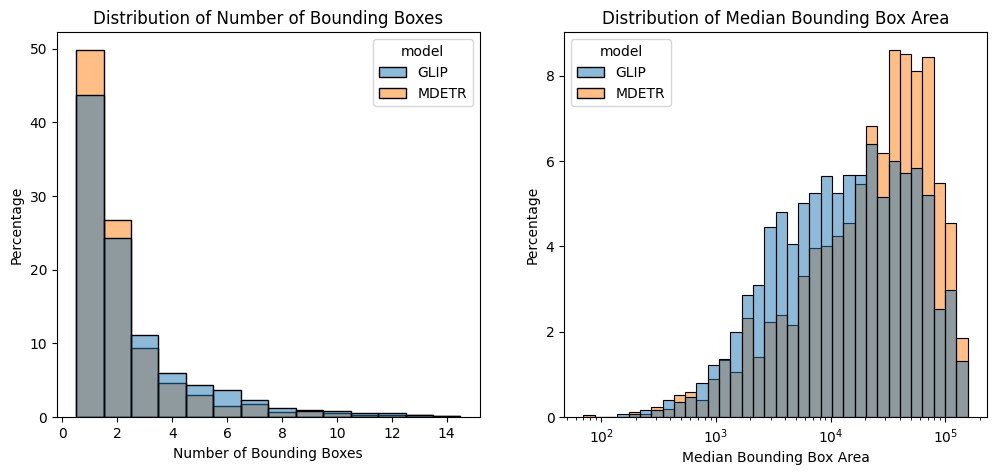

In [142]:
columns = [['median_bbox_area_GLIP_caption', 'median_bbox_area_GLIP_title'], ['median_bbox_area_MDETR_caption', 'median_bbox_area_MDETR_title']]
model_names = ['GLIP', 'MDETR']
fig, ax = plt.subplots(1,2, figsize=(12, 5))
show_dist(df, ax[1], columns, 'median_bbox_area', model_names, log_scale=True)
ax[1].set_ylabel('Percentage')
ax[1].set_xlabel('Median Bounding Box Area')
ax[1].set_title('Distribution of Median Bounding Box Area')


# do the same as above but for num_bbox
columns = [['num_bbox_GLIP_caption', 'num_bbox_GLIP_title'], ['num_bbox_MDETR_caption', 'num_bbox_MDETR_title']]
model_names = ['GLIP', 'MDETR']
filterd_df = df.copy()
for column in columns:
    for column_ in column:
        filterd_df = filterd_df.loc[(filterd_df[column_] < 15) & (filterd_df[column_] > 0)]

show_dist(filterd_df,ax[0], columns, 'num_bbox', model_names, log_scale=False, discrete=True)
ax[0].set_xlabel('Number of Bounding Boxes')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Distribution of Number of Bounding Boxes')

plt.savefig('../docs/assets/num_bbox_median_bbox_area.png', dpi=300)
plt.show()

# show_dist_plotly(df, columns, 'median_bbox_area', model_names)

In [117]:
df.loc[df.num_bbox_GLIP_caption > 20] 

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,...,min_bbox_area_GLIP_caption,max_bbox_area_GLIP_caption,median_bbox_area_GLIP_caption,num_bbox_GLIP_title,min_bbox_area_GLIP_title,max_bbox_area_GLIP_title,median_bbox_area_GLIP_title,choice,isGLIP,isCaption
1199,1411,PRMA_00314_2k_324w.jpg,photograph of a group of men in suits and ties.,GLIP,caption,"[0.7276865, 0.69031113, 0.6652922, 0.6630239, ...","[[14.036285, 23.695118, 304.46747, 227.72523],...","[men, suits, suits, suits, suits, suits, suits...",2096.0,photograph of a group of men in suits and ties.,...,184.0,59256.0,2574.0,9.0,2607.0,59797.0,3977.0,"[1, 0, 0, 0]",True,True
1429,827,JOMU_06934_2k_324w.jpg,photograph of a group of children holding ball...,GLIP,caption,"[0.75808555, 0.7580567, 0.7517305, 0.7514857, ...","[[87.370415, 114.64286, 103.48789, 130.70679],...","[balloons, balloons, children, children, child...",1275.0,photograph of a group of children holding ball...,...,211.0,25026.0,359.0,0.0,NaN,NaN,NaN,"[1, 0, 0, 0]",True,True
1449,916,JOMU_11730_2k_324w.jpg,a group of men in white shirts walking down a ...,GLIP,caption,"[0.7628221, 0.7510368, 0.7229012, 0.7133434, 0...","[[201.78867, 278.784, 262.4696, 322.4782], [69...","[white shirts, white shirts, men, white shirts...",1371.0,a group of men in white shirts walking down a ...,...,514.0,69232.0,1544.0,1.0,70453.0,70453.0,70453.0,"[1, 0, 0, 0]",True,True


In [45]:
temp_df.index = np.arange(len(temp_df))

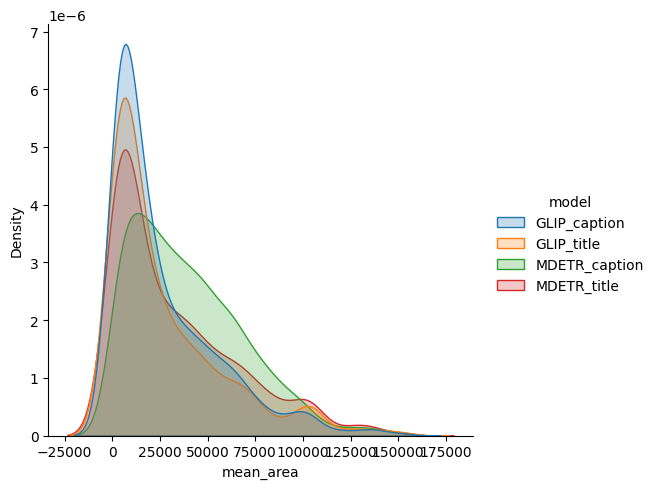

In [51]:
sns.displot(temp_df, x="mean_area", hue="model", kind="kde", fill=True)

In [47]:
temp_df.loc[temp_df['mean_area'] < 0]

,mean_area,model
